<a href="https://colab.research.google.com/github/sai-2005-ai/Resume_Skill_Extracter/blob/main/resume_skill_extraction_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Using cached tensorflow-2.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached tensorflow_federated-0.87.0-py3-none-manylinux_2_31_x86_64.whl.metadata (19 kB)
  Using cached numpy-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.8.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached numpy-2.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached ml_dtypes-0.4.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
INFO: pip is looking at multiple versions of tensorflow-federated to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorflow_federated-0.86.0-py3-none-manylinux_2_31_x86_64.whl.metadata (19 kB)
  Using cached tensorflow_federated-0.85.0-py3-none-manylinux_2_31_x86_64.whl.metadata (19 kB)
  Us

Saving UpdatedResumeDataSet.csv.zip to UpdatedResumeDataSet.csv (1).zip
Dataset Loaded Successfully! Sample Data:
       Category                                             Resume
0  Data Science  Skills * Programming Languages: Python (pandas...
1  Data Science  Education Details \r\nMay 2013 to May 2017 B.E...
2  Data Science  Areas of Interest Deep Learning, Control Syste...
3  Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4  Data Science  Education Details \r\n MCA   YMCAUST,  Faridab...
Preprocessing Done. Sample:
                                              Resume  \
0  Skills * Programming Languages: Python (pandas...   
1  Education Details \r\nMay 2013 to May 2017 B.E...   
2  Areas of Interest Deep Learning, Control Syste...   
3  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...   
4  Education Details \r\n MCA   YMCAUST,  Faridab...   

                                      cleaned_resume  
0  skills  programming languages python pandas nu...  
1  educat

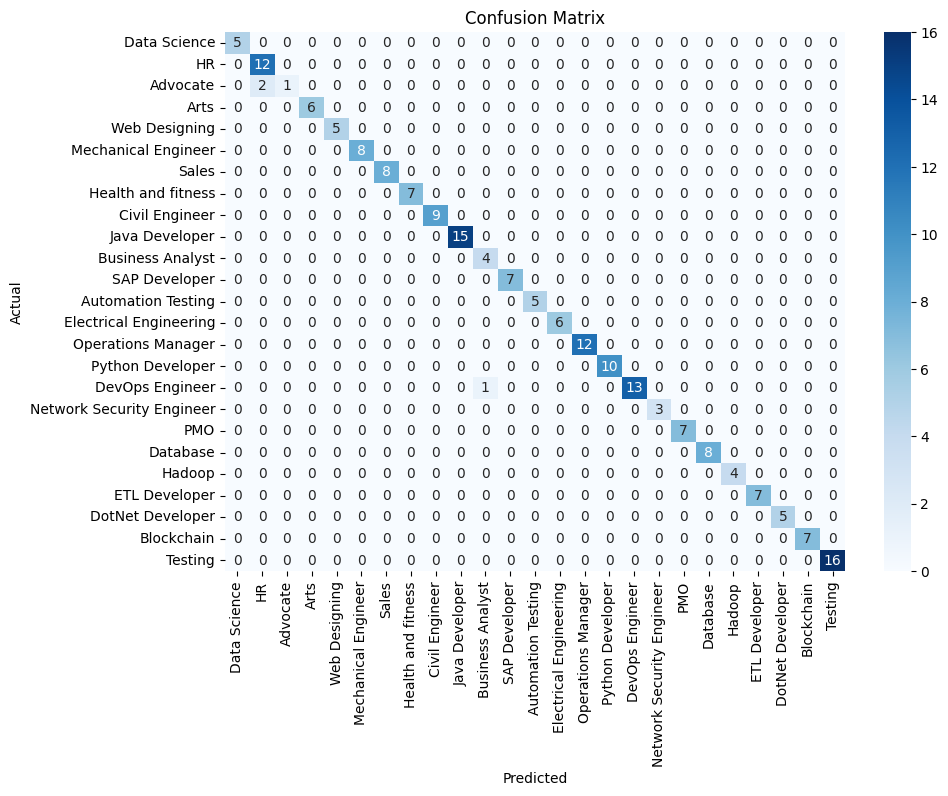

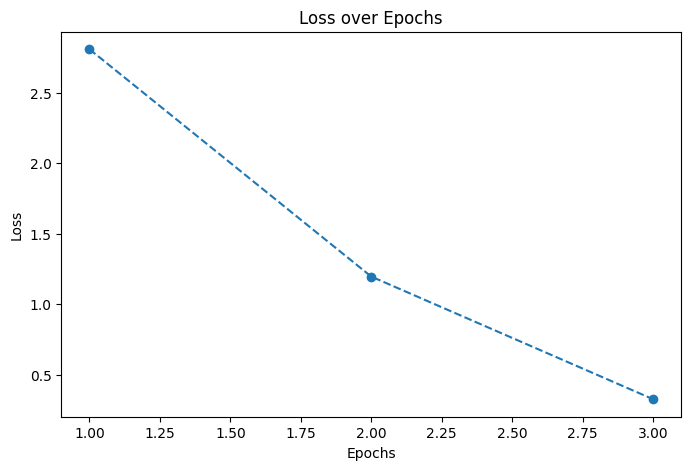

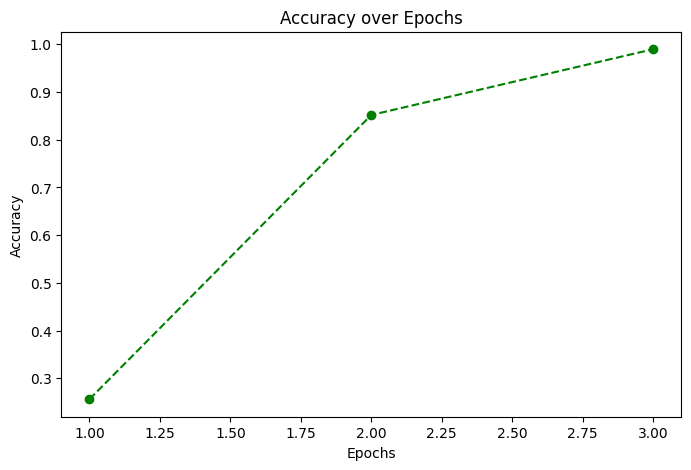

Training & Evaluation Completed Successfully!


In [ ]:
# Required Libraries
import numpy as np
import pandas as pd
import re
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from google.colab import files

# Upload Dataset
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))
print("Dataset Loaded Successfully! Sample Data:")
print(df.head())

#  Text Preprocessing Function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    return text

df['cleaned_resume'] = df['Resume'].apply(preprocess_text)
print("Preprocessing Done. Sample:")
print(df[['Resume', 'cleaned_resume']].head())

#  Load DistilBERT Tokenizer (Faster than BERT)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

#  Dataset Class for Tokenization
class ResumeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):  #  Reduced max_length to 128
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

#  Convert Labels to Numbers
labels = {category: idx for idx, category in enumerate(df['Category'].unique())}
df['label'] = df['Category'].map(labels)

#  Train-Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['cleaned_resume'].values, df['label'].values, test_size=0.2, random_state=42
)

#  Create Dataset and DataLoaders
train_dataset = ResumeDataset(train_texts, train_labels, tokenizer)
test_dataset = ResumeDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  #  Increased batch_size to 8
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

#  Define DistilBERT-based Classification Model
class DistilBERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DistilBERTClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = self.dropout(outputs.last_hidden_state[:, 0, :])  # Take CLS token output
        x = self.fc(x)
        return x

#  Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(labels)
model = DistilBERTClassifier(num_classes).to(device)

#  Loss & Optimizer (Using AdamW for faster training)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

#  Training Function
def train_model(model, train_loader, criterion, optimizer, epochs=3):  #  Reduced epochs to 3
    model.train()
    loss_values = []
    accuracy_values = []
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        loss_values.append(avg_loss)
        accuracy_values.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return loss_values, accuracy_values

#  Train Model
loss_values, accuracy_values = train_model(model, train_loader, criterion, optimizer)

#  Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    #  Compute Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(labels.keys()), yticklabels=list(labels.keys()))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1

#  Evaluate Model
evaluate_model(model, test_loader)

#  Plot Loss over Epochs
plt.figure(figsize=(8,5))
plt.plot(range(1, 4), loss_values, marker='o', linestyle='--')
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

#  Plot Accuracy over Epochs
plt.figure(figsize=(8,5))
plt.plot(range(1, 4), accuracy_values, marker='o', linestyle='--', color='green')
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

print("Training & Evaluation Completed Successfully!")
